## 04. Modelado con Machine Learning India

In [1]:
import warnings
from src.utils_functions import *
from src.features import *

# Display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format
sns.set_theme(context='notebook', style=plt.style.use('dark_background'))
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
# Modelado
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso
from glum import GeneralizedLinearRegressor
from sklearn.metrics import mean_absolute_error

# Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [3]:
# Carga y lectura de los datos
data = pd.read_excel('datasets\\raw\\Iron Ore.xls',
                     skiprows=list(range(10)),
                     index_col=[0])

# Definimos la frecuencia de nuestras series temporales
data = data.asfreq('MS')
data

,PIORECRUSDM
observation_date,
1990-01-01,14.0500
1990-02-01,14.0500
1990-03-01,14.0500
1990-04-01,14.0500
1990-05-01,14.0500
...,...
2023-05-01,104.5217
2023-06-01,113.0909
2023-07-01,113.9762


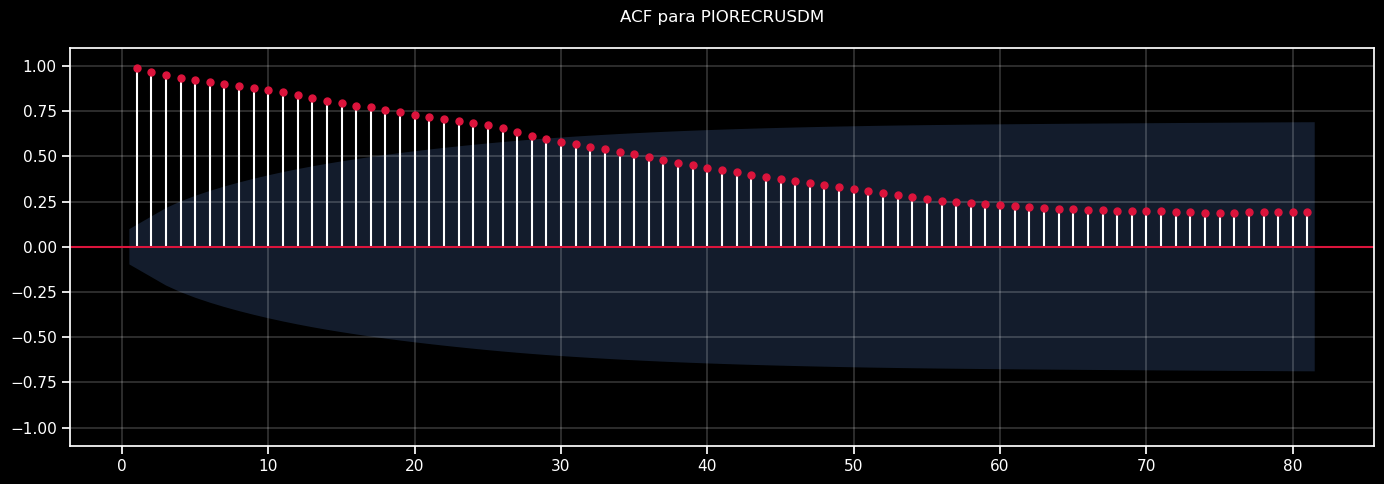

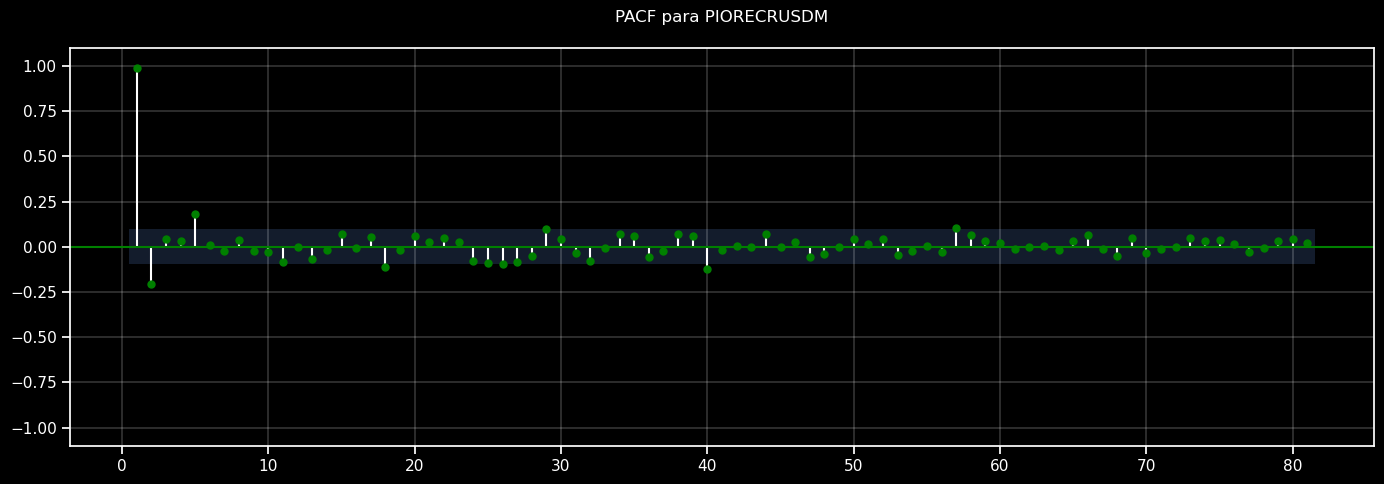

In [4]:
# Gráfico de función de autocorrelación y autocorrelación parcial
acf_y_pcf(data=data, lags=len(data)//5)

In [5]:
# Variables Generales
# ==============================================================================
target = 'PIORECRUSDM'

# Punto de corte
fin_entrenamiento = data.iloc[int(data.shape[0]*0.8):].index[0]

## **Baseline - Simulación del Random Walk**

A la hora de generar un modelo predictivo es conveniente identificar un modelo de línea base, o baseline, sobre el que ir comparando cada una de las iteraciones o modelos propuestos. En el caso de las finanzas, acorde a la teoría del paseo aleatorio o Random Walk, los precios de mercado se comportan de manera aleatoria y no dependiente de su serie temporal. De esta manera, la mejor estimación para el valor $t_{n+1}$ es el valor $t_n$ más un cambio impredecible.

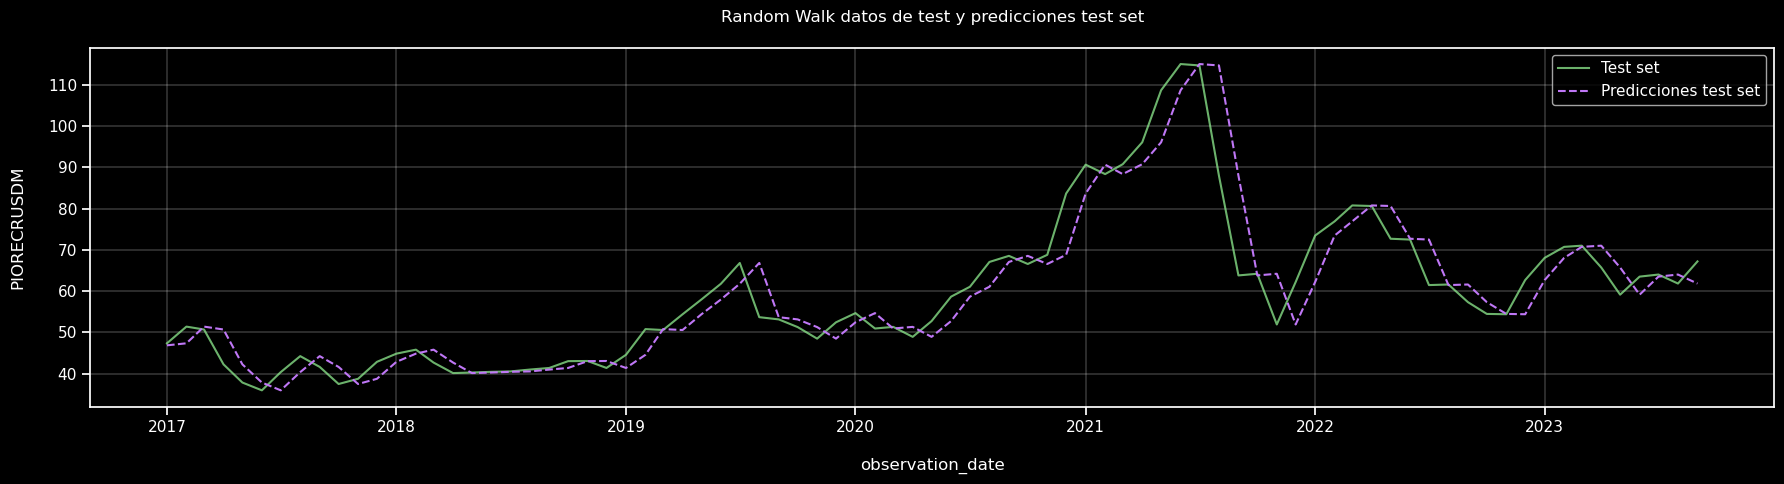

In [6]:
# Simulación Random Walk
# ==============================================================================
np.random.seed(42)
serie = data[target]

# Calculando las diferencias de la serie
diferencias = serie.diff().fillna(0)

# Introduciendo ruido a las diferencias
ruido = np.random.normal(loc=0.5, scale=0.001, size=len(diferencias))

# Construyendo el random walk a partir de la serie
random_walk = pd.DataFrame(serie.iloc[0] + diferencias.cumsum() * ruido, columns=[target])
random_walk['preds'] = random_walk[target].shift()

y_true = random_walk.loc[fin_entrenamiento:, target]
y_pred = random_walk.loc[fin_entrenamiento:, 'preds']

# Graficando
plt.figure(figsize=(18, 5))
plt.plot(y_true.index, y_true, label='Test set', color='lightgreen', alpha=0.75, linestyle='-')
plt.plot(y_pred.index, y_pred, label='Predicciones test set', color='xkcd:light purple', linestyle='dashed')
plt.title('Random Walk datos de test y predicciones test set\n')
plt.xlabel(f'\n{y_true.index.name}')
plt.ylabel(f'{y_true.name}\n')
plt.legend()
plt.grid(color='white', linestyle='-', linewidth=0.25)
plt.tight_layout()

In [7]:
# Dataframe de rendimiento del modelo de línea base
rendimiento = pd.DataFrame({
    'Modelo': 'Random Walk',
    'MAE': mean_absolute_error(y_true, y_pred),
    'MAPE': loss_function(y_true, y_pred)[0],
    'RMSE': loss_function(y_true, y_pred)[1],
    'RMSPE': loss_function(y_true, y_pred)[2],
    'R²': loss_function(y_true, y_pred)[3],
    'exog': [False]
})

rendimiento

,Modelo,MAE,MAPE,RMSE,RMSPE,R²,exog
0,Random Walk,4.2613,0.0699,6.3913,0.0983,0.8686,False


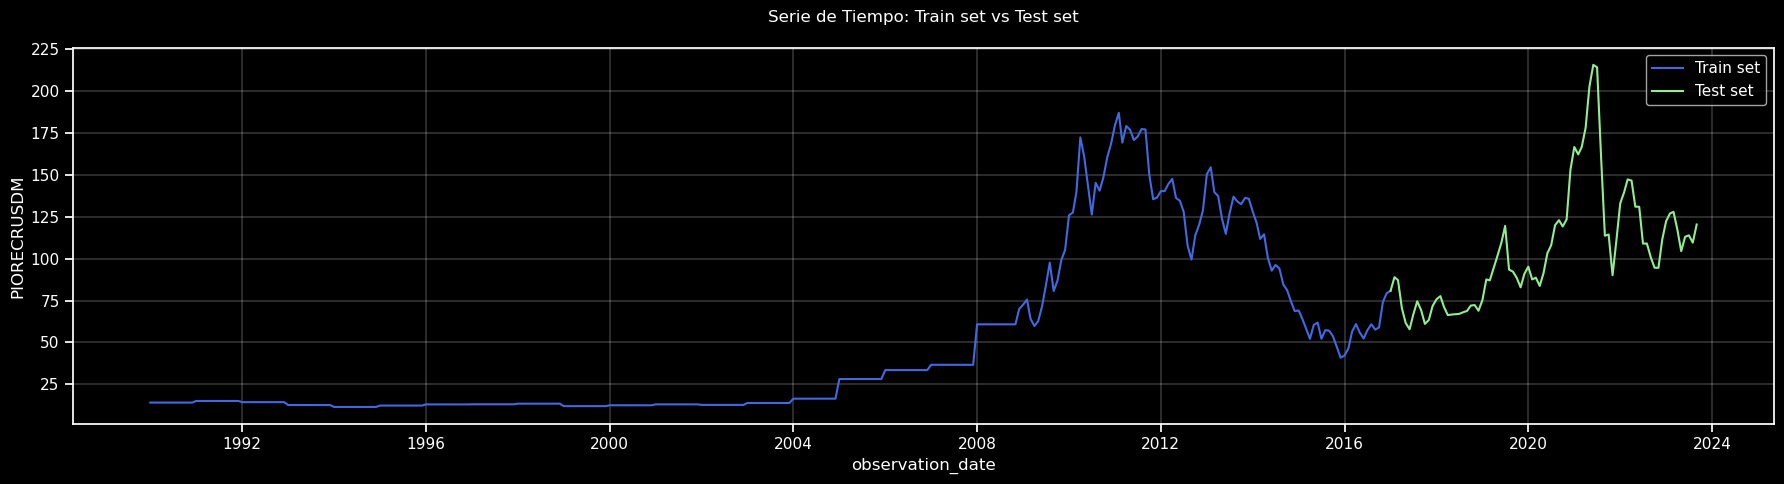

In [8]:
# Graficamos los datos de entrenamiento y prueba
plotting_train_test_pred(train_data=data.loc[:fin_entrenamiento, target],
                         test_data=data.loc[fin_entrenamiento:, target])

In [9]:
# Modelado
# ==============================================================================
lags_linear = 30
lags_no_linear = 10
steps = 36
seed = 55
tmp_feats = ['month', 'week', 'day_of_week', 'day_of_month', 'year']

# Hiperparámetros de los regresores
param_grid_linear_models = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

param_grid_no_linear_models = {
    'n_estimators': list(range(600, 901, 100)),
    'max_depth': [3, 4],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Lista de regresores empaquetados con sus respectivos diccionarios de hiperparámetros y pipelines
regresores = [
    # Lineales
    (Ridge(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    (Lasso(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    (GeneralizedLinearRegressor(random_state=seed), param_grid_linear_models, tmp_feats, pipeline_linear_models),
    
    # No lineales
    (XGBRegressor(random_state=seed, tree_method='gpu_hist', n_jobs=-1), param_grid_no_linear_models, tmp_feats, pipeline_no_linear_models),
    (LGBMRegressor(random_state=seed, verbose=-1, n_jobs=-1), param_grid_no_linear_models, tmp_feats, pipeline_no_linear_models)
]

# Inicialización del diccionario de resultados
resultados = dict()

for model, param_grid, tmp, pipeline in regresores:
    # Ingeniería de variables
    # ==============================================================================
    data_transformada = pipeline(data=data, tmp=tmp, target=target, n_windows=3)
    variables_exogenas = [var for var in data_transformada.columns if var != target]
    
    # Forecaster
    # ==============================================================================
    if isinstance(model, (Ridge, Lasso, GeneralizedLinearRegressor)):
        forecaster = ForecasterAutoreg(
            regressor=model,
            lags=lags_linear,
            transformer_y=MinMaxScaler()
        )
    
        # Búsqueda de lags para el componente autorregresivo
        lags_grid = list(range(1, lags_linear+1))    
        
    else:
        forecaster = ForecasterAutoreg(
            regressor=model,
            lags=lags_no_linear,
            differentiation=1
        )
        
        # Búsqueda de lags para el componente autorregresivo
        lags_grid = list(range(1, lags_no_linear+1))
    
    # Búsqueda en grilla de hiperparámetros y lags
    # ==============================================================================
    resultados_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data_transformada.loc[:, target], # Datos entrenamiento y validación
                            exog               = data_transformada.loc[:, variables_exogenas], # Variables exógenas utilizadas en cada iteración
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = steps, # Número de pasos hacia adelante optimizando el modelo durante la búsqueda de la mejor combinación de parámetros
                            refit              = False,
                            metric             = 'mean_absolute_error',
                            initial_train_size = data_transformada.loc[:fin_entrenamiento, target].shape[0], # El modelo se entrena con los datos de entrenamiento
                            return_best        = True,
                            n_jobs             = -1,
                            verbose            = False,
                            fixed_train_size   = False,
                            show_progress      = False
)
    
    # Backtesting datos de validación
    # ==============================================================================
    mae, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data_transformada.loc[:, target], # Datos entrenamiento y validación
                            exog               = data_transformada.loc[:, variables_exogenas], # Variables exógenas utilizadas en cada iteración
                            initial_train_size = data_transformada.loc[:fin_entrenamiento, target].shape[0], # El modelo se entrena con los datos de entrenamiento
                            steps              = steps, # La cantidad de pasos hacia adelante que el modelo va a predecir en cada iteración del backtest
                            refit              = False,
                            metric             = 'mean_absolute_error',
                            n_jobs             = -1,
                            interval           = [5, 95],
                            verbose            = False, # True para ver detalles del backtesting
                            fixed_train_size   = False,
                            show_progress      = False                           
)   
    
    # Función de pérdida para medir el rendimiento de los modelos
    # ==============================================================================
    mape, rmse, rmspe, r2 = loss_function(
                        y_true = data_transformada.loc[fin_entrenamiento:, target][1:],
                        y_pred = predicciones['pred']
)
    
    # Almacenar las predicciones y las métricas al Dataframe de rendimientos
    # ==============================================================================
    nuevo_rendimiento = pd.DataFrame({
        'Modelo': [type(model).__name__],
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'RMSPE': rmspe,
        'R²': r2,
        'exog': [True]
    })
    
    # Actualizamos los rendimientos de los modelos
    rendimiento = pd.concat([rendimiento, nuevo_rendimiento], ignore_index=True)
    
    # Almacenar el nombre del modelo, las predicciones y el objeto del modelo en el diccionario
    resultados[type(model).__name__] = {
        'nombre': type(model).__name__,
        'predicciones': predicciones, # Contiene un diccionario con las predicciones y los intervalos de confianza
        'modelo_objeto': model,
        'forecaster': forecaster,
        'vars_exog': data_transformada
    }

Number of models compared: 150.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 1}
  Backtesting metric: 9.68049844962739

Number of models compared: 150.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 8.659285461826752

Number of models compared: 150.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 9.550820984741225

Number of models compared: 240.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 600}
  Backtesting metric: 23.65387073168558

Number of models compa

In [10]:
# Rendimiento de los modelos
# ==============================================================================
# Ordenamos de acuerdo a las métricas de nuestro interés
df_rendimiento = rendimiento.sort_values(by=['RMSE', 'MAE', 'RMSPE', 'MAPE', 'R²']).set_index('Modelo')

# Ajustar nombres de columnas e índices
df_rendimiento.columns.name = None
df_rendimiento.index.name = None
df_rendimiento

,MAE,MAPE,RMSE,RMSPE,R²,exog
Random Walk,4.2613,0.0699,6.3913,0.0983,0.8686,False
Lasso,8.6593,0.0805,12.6148,0.1096,0.8723,True
GeneralizedLinearRegressor,9.5508,0.0845,13.1973,0.1082,0.8602,True
Ridge,9.6805,0.0873,13.6151,0.1156,0.8512,True
XGBRegressor,23.6539,0.1993,35.8237,0.2489,-0.0299,True
LGBMRegressor,24.1835,0.2063,35.8808,0.2515,-0.0332,True


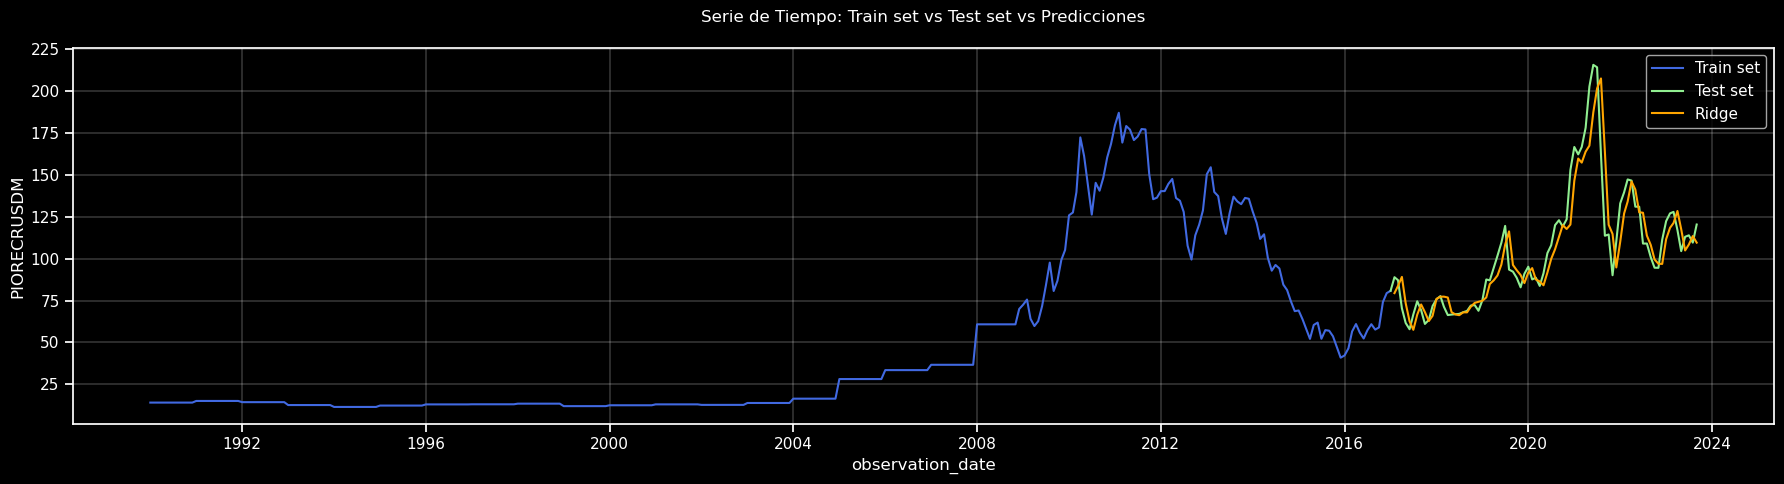

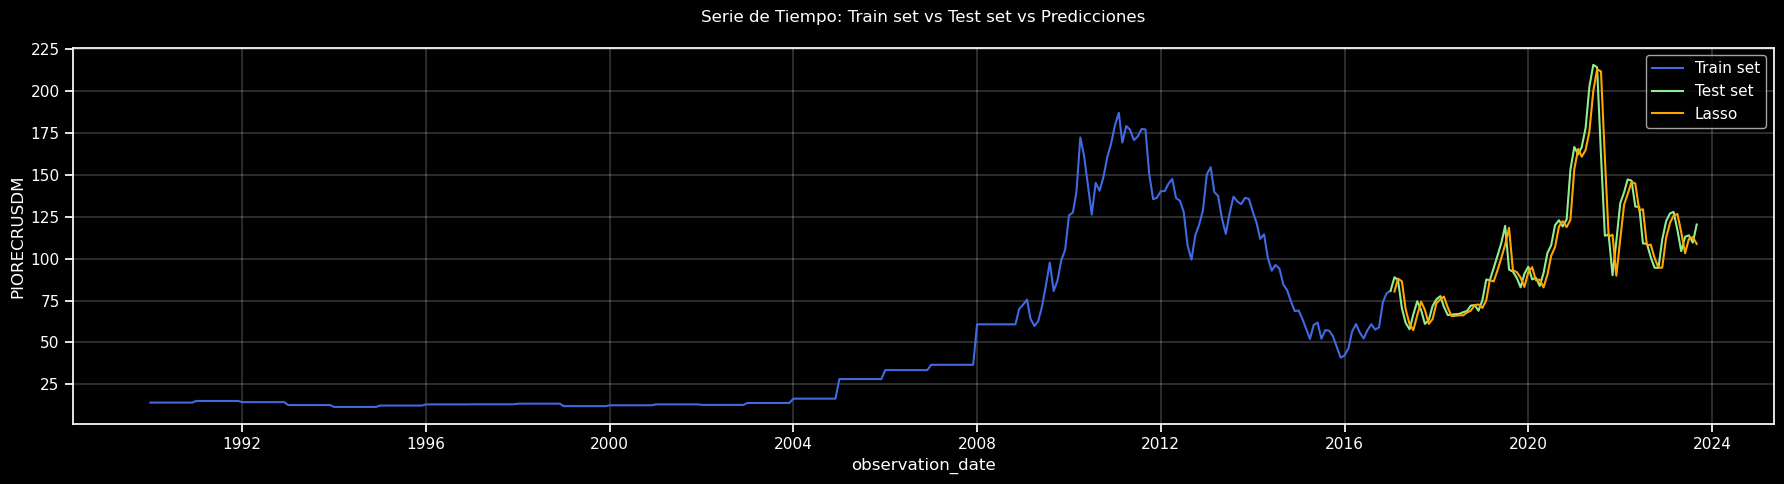

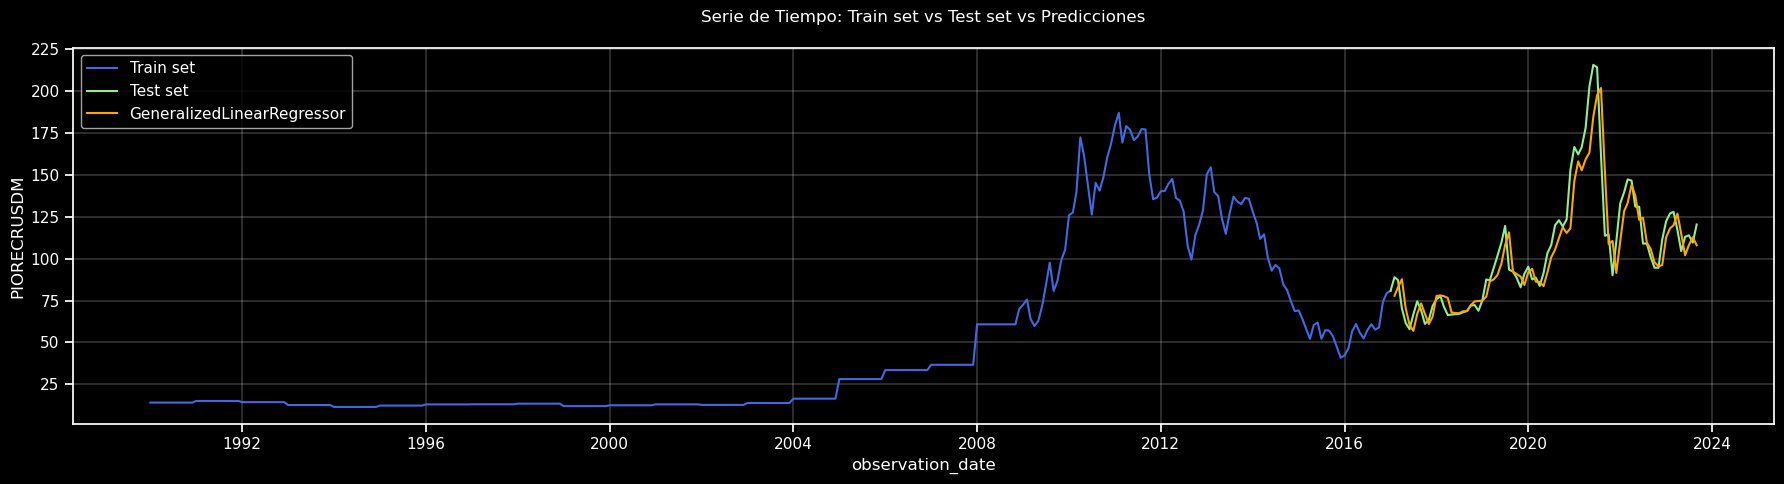

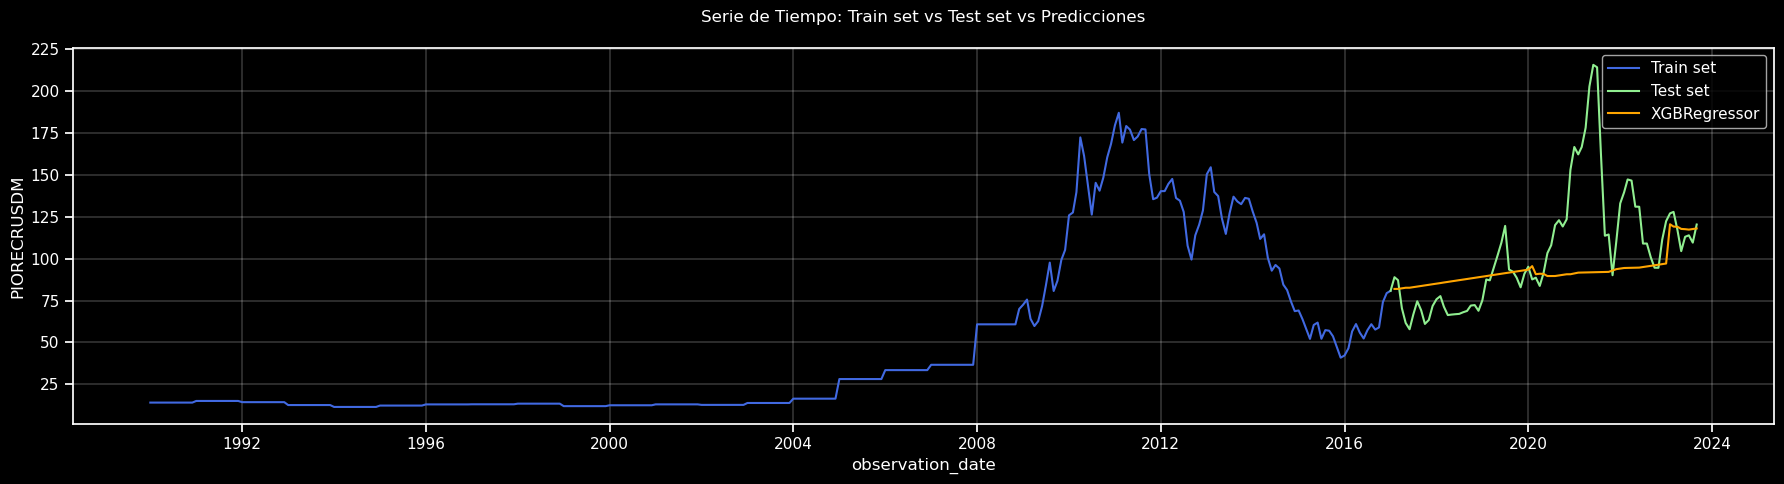

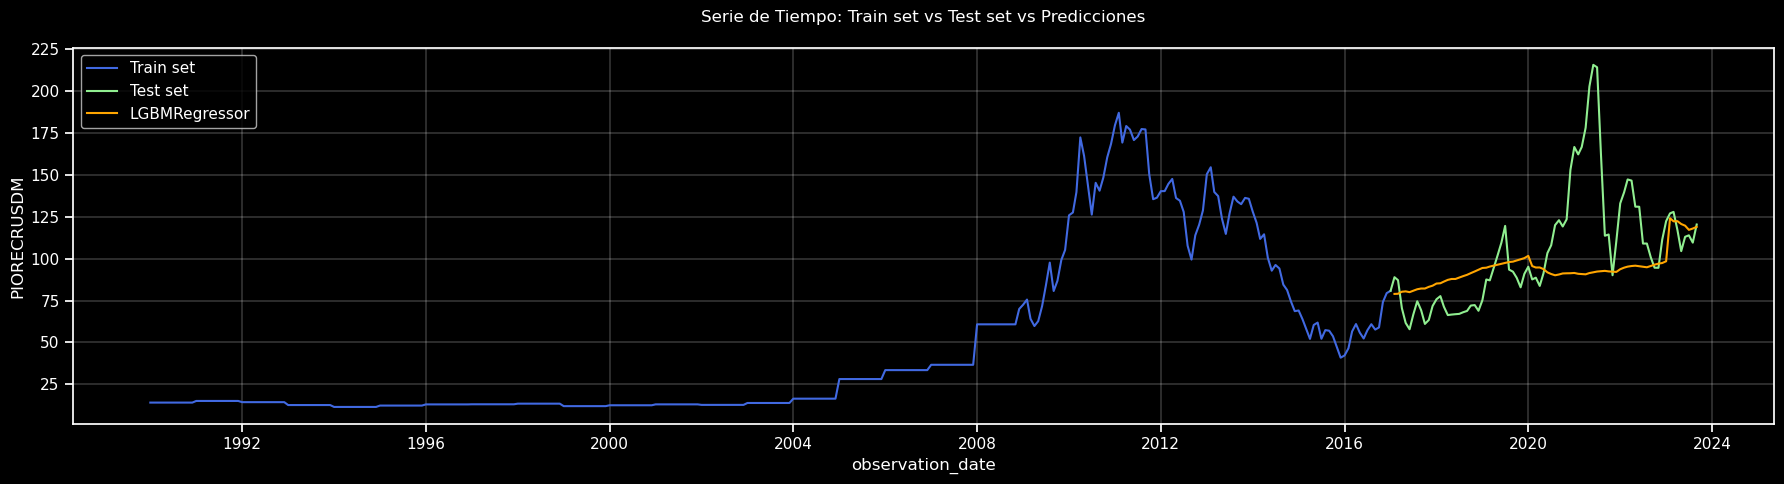

In [11]:
# Resultados
# ==============================================================================
for name, model_data in resultados.items():
    plotting_train_test_pred(train_data=data.loc[:fin_entrenamiento, target],
                             test_data=data.loc[fin_entrenamiento:, target],
                             modelo=model_data['modelo_objeto'],
                             preds_data=model_data['predicciones']['pred'])

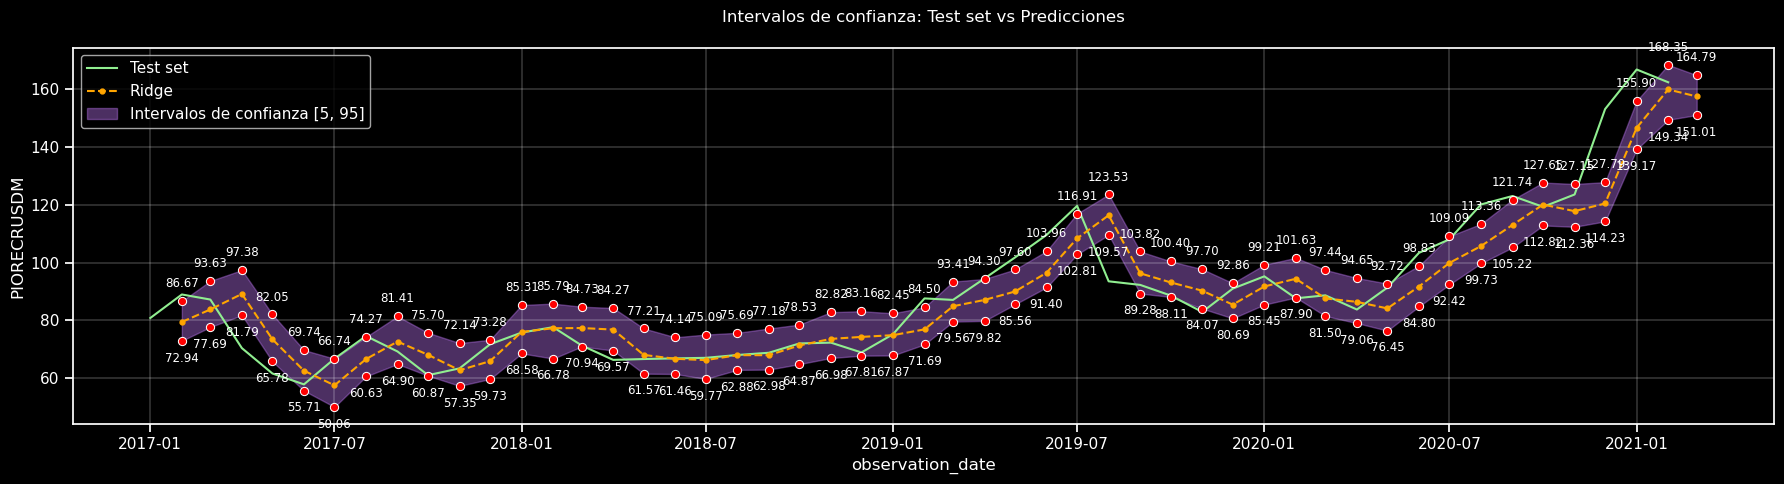

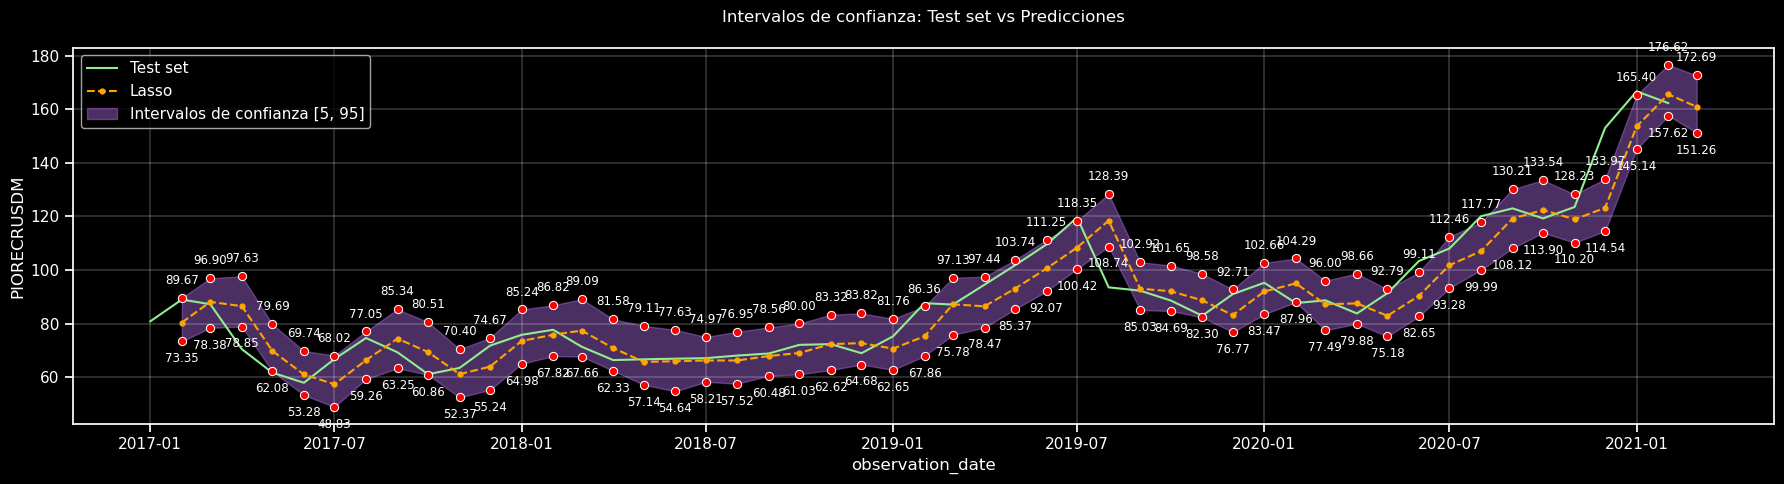

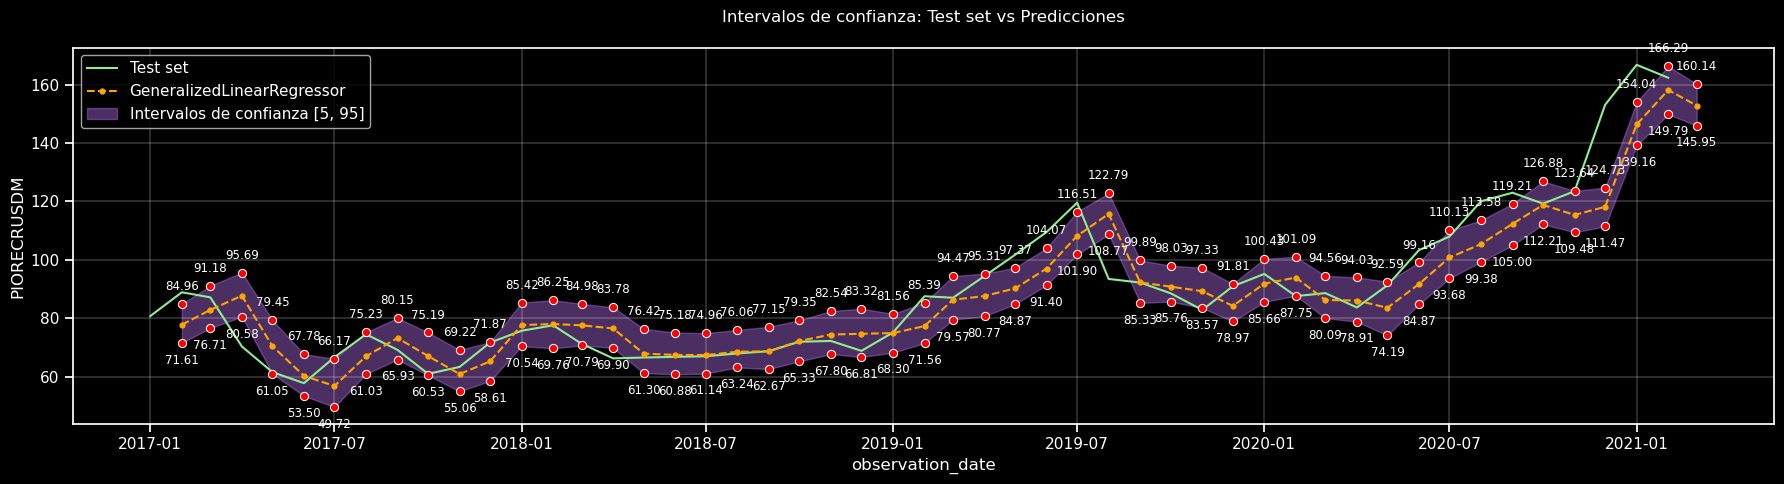

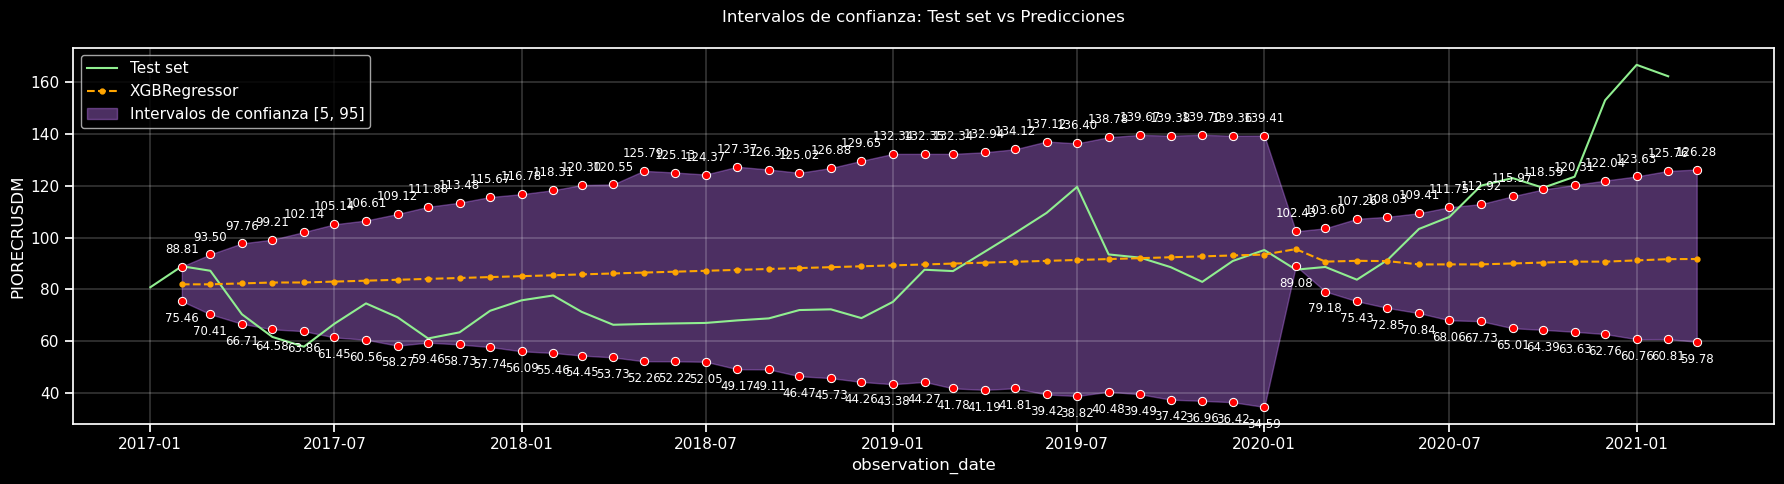

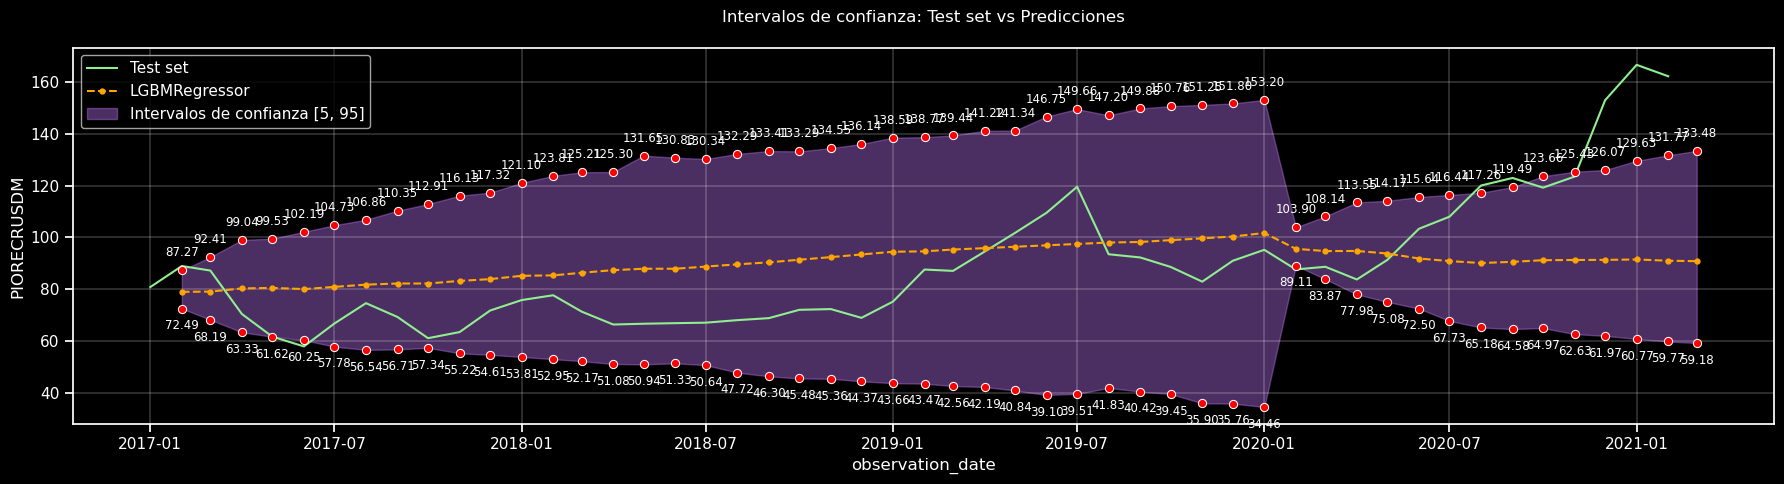

In [12]:
# Intervalos de confianza en el limite 5 y 95
# ==============================================================================
for name, model_data in resultados.items():
    plotting_confidence_intervals_preds(test_data=data.loc[fin_entrenamiento:, target][:50],
                                        modelo=model_data['modelo_objeto'],
                                        preds_data=model_data['predicciones']['pred'][:50],
                                        intervals_preds=model_data['predicciones'][:50])

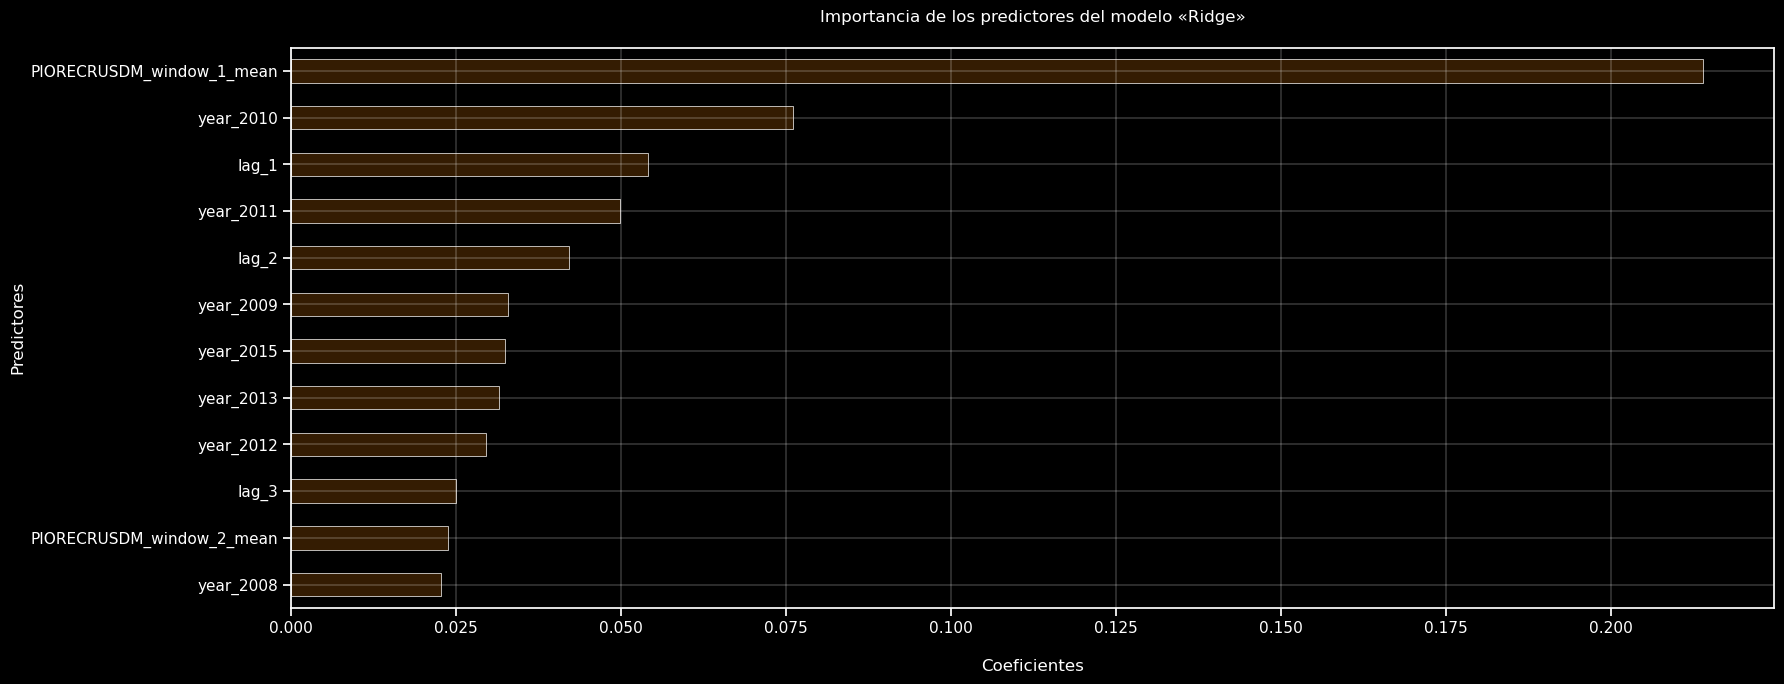

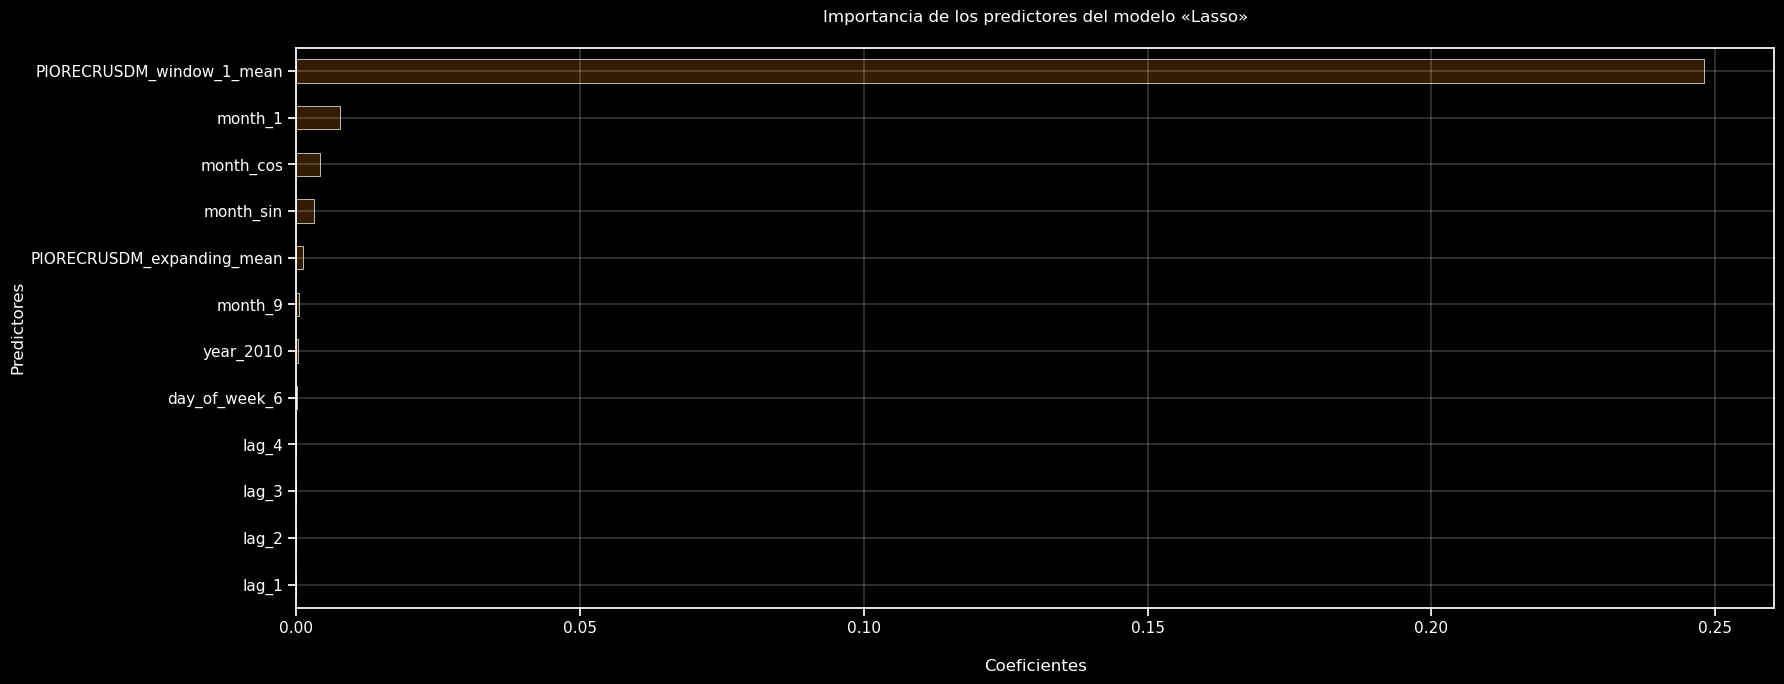

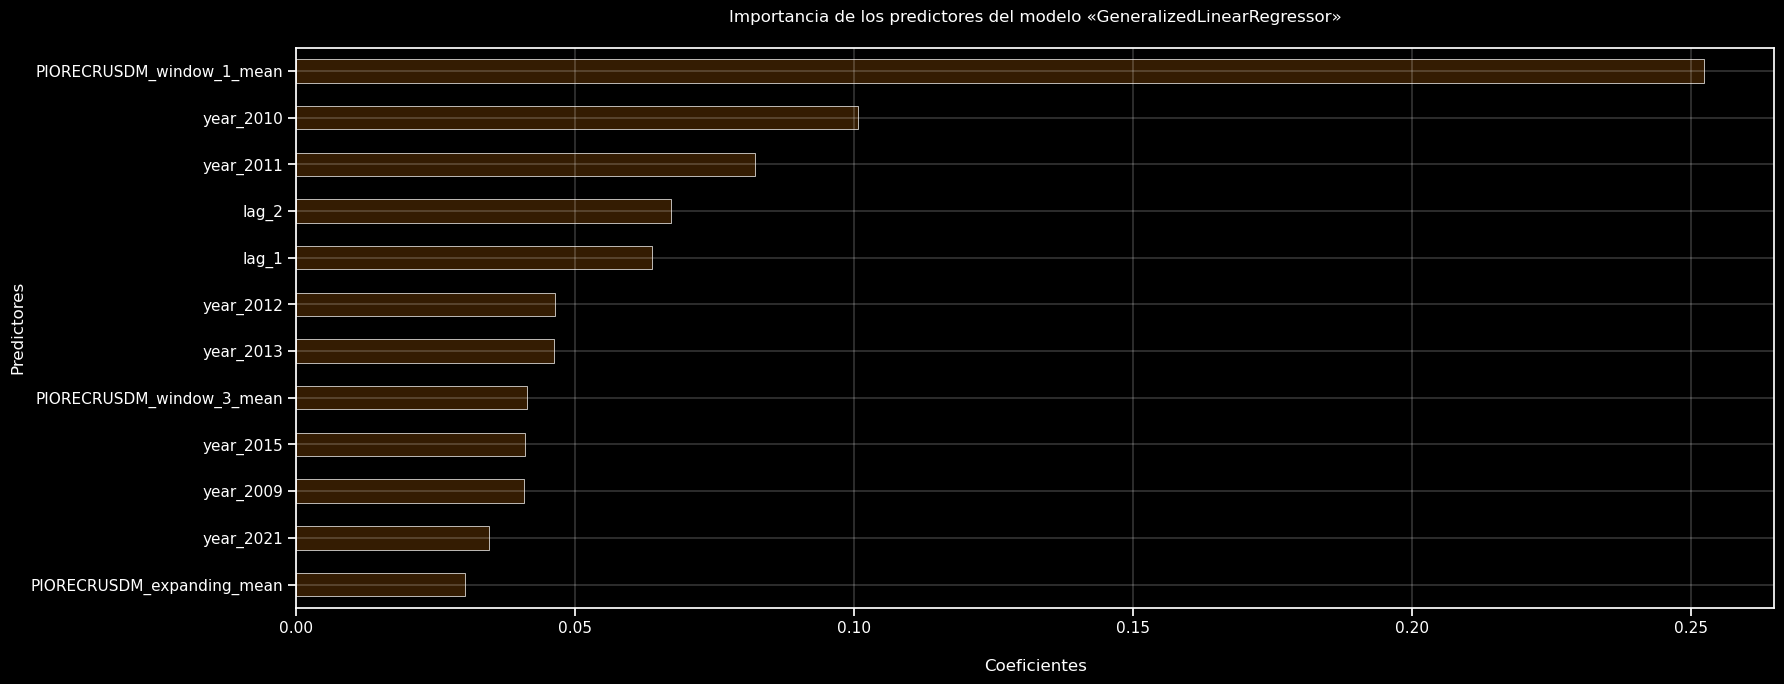

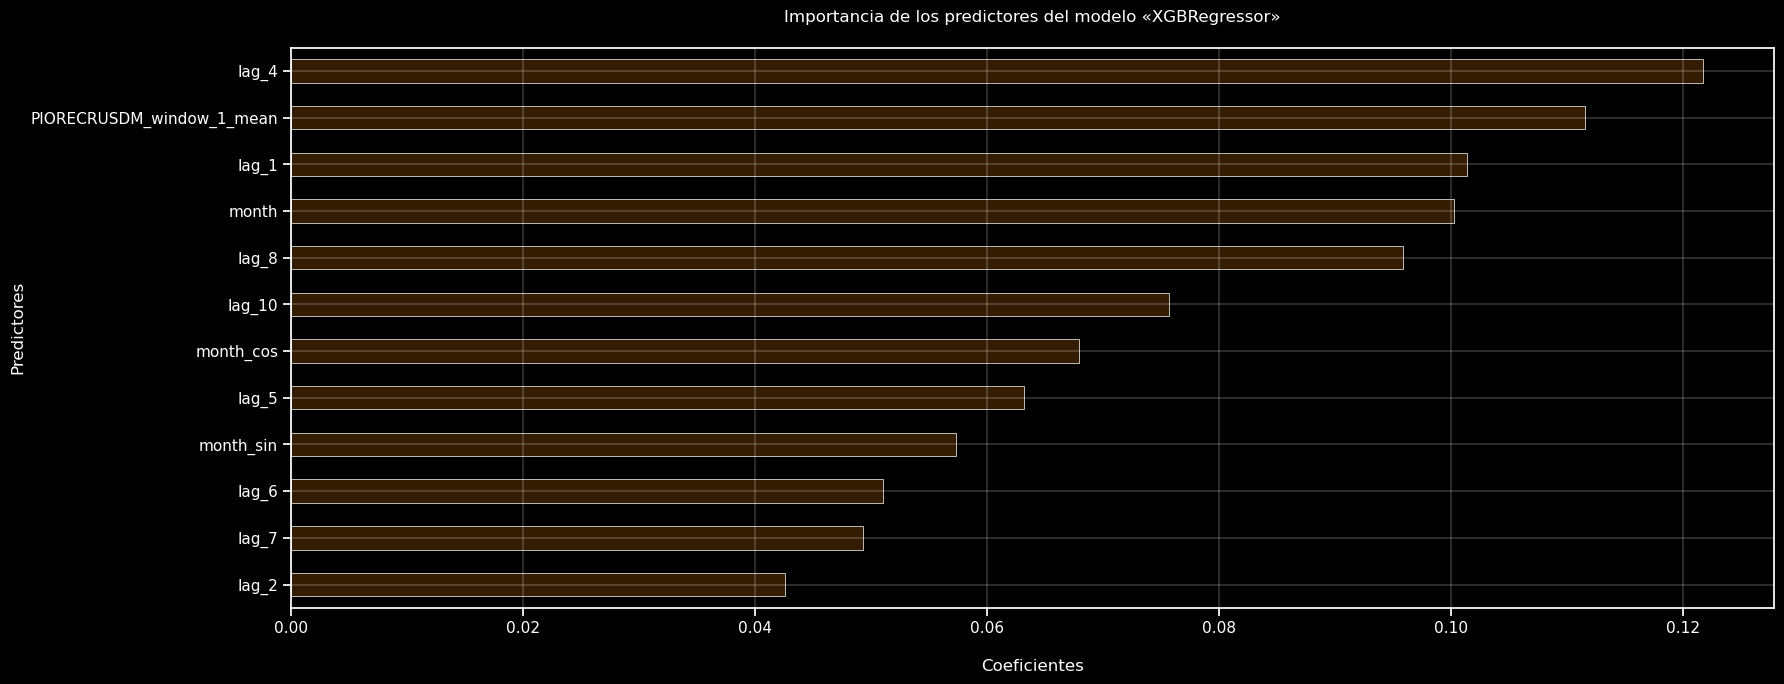

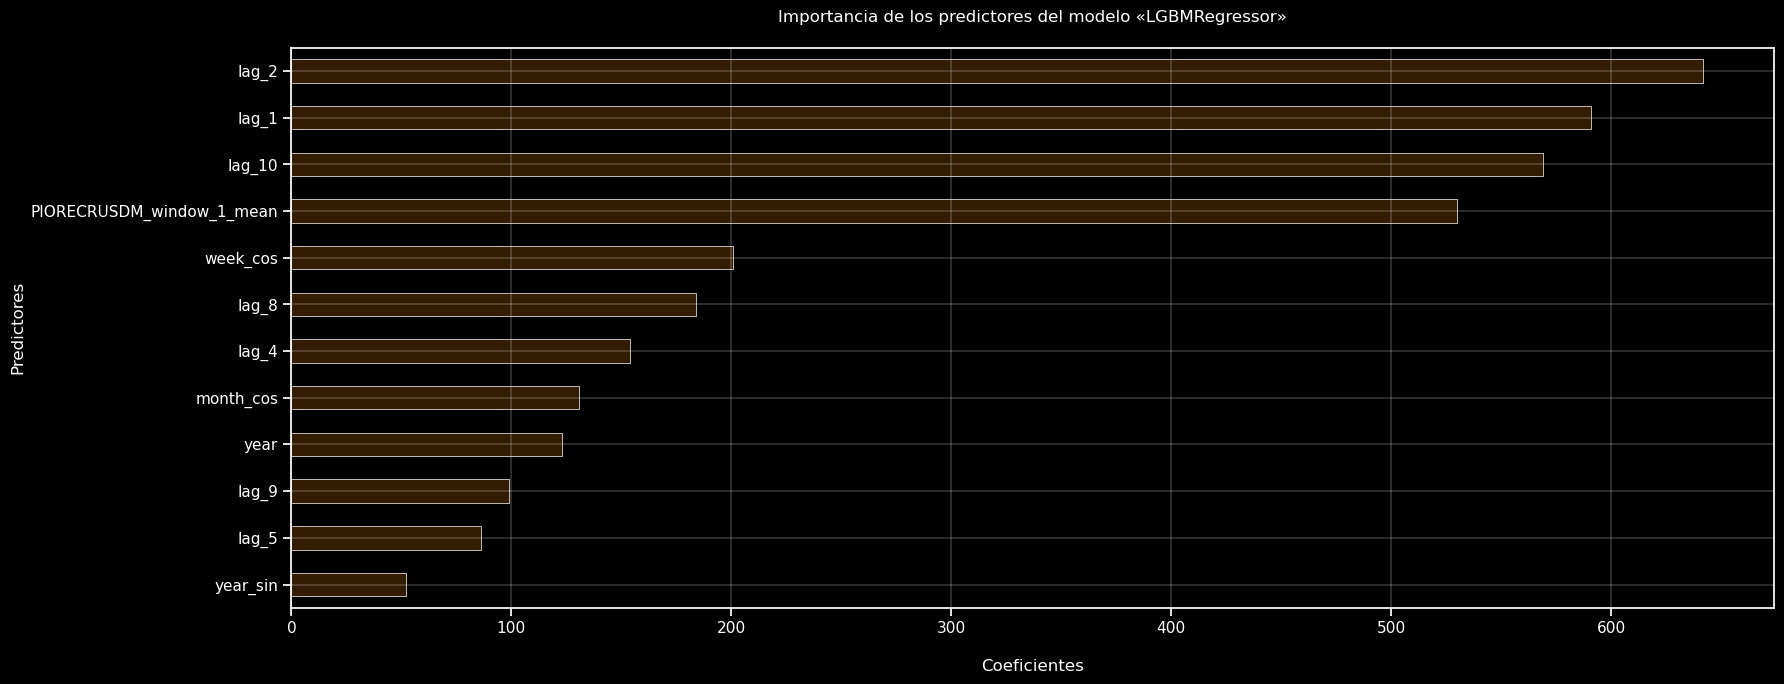

In [13]:
# Importancia de los predictores del modelo
# ==============================================================================
for model_name in resultados.keys():
    importances = resultados[model_name]['forecaster'].get_feature_importances()
    
    # Si no hay importancias o el DataFrame está vacío, imprime un mensaje y continua con el siguiente modelo
    if importances is None or importances.empty:
        continue
    
    # Si hay importancias, procedemos a graficar
    importances['importance'] = importances['importance'].abs()
    importances = importances.nlargest(12, 'importance').sort_values('importance')
    
    importances.set_index('feature', inplace=True)
    importances.plot.barh(
        figsize=(18, 7), 
        color='xkcd:dark brown', 
        width=0.5,
        edgecolor='white', 
        lw=0.5, 
        legend=False
    )

    # Agregar etiquetas y títulos
    plt.title(f'Importancia de los predictores del modelo «{model_name}»\n')
    plt.xlabel('\nCoeficientes')
    plt.ylabel('Predictores')
    plt.grid(color='white', linestyle='-', linewidth=0.25)
    plt.tight_layout()
    plt.show()


In [14]:
# Revisamos los datos de entrada y el target del mejor modelo
# ==============================================================================
best_model = resultados[df_rendimiento.index[1]]
data_transformada = best_model['vars_exog']

X_train, y_train = best_model['forecaster'].create_train_X_y(
                        y = data_transformada.loc[:fin_entrenamiento, target],
                        exog = data_transformada.loc[:fin_entrenamiento, data_transformada.columns])
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,PIORECRUSDM,PIORECRUSDM_window_1_mean,PIORECRUSDM_window_2_mean,PIORECRUSDM_window_3_mean,PIORECRUSDM_expanding_mean,month_sin,month_cos,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week_1,week_5,week_9,week_13,week_18,week_22,week_26,week_31,week_35,week_40,week_44,week_48,week_14,week_27,week_23,week_36,week_49,week_53,week_17,week_30,week_39,week_52,week_10,week_45,day_of_week_0,day_of_week_3,day_of_week_6,day_of_week_1,day_of_week_4,day_of_week_2,day_of_week_5,day_of_month_1,year_1990,year_1991,year_1992,year_1993,year_1994,year_1995,year_1996,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023
observation_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1992-07-01,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,14.3100,-0.8378,-0.8380,-0.8382,-0.7622,-0.5000,-0.8660,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1992-08-01,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,14.3100,-0.8378,-0.8380,-0.8382,-0.7626,-0.8660,-0.5000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1992-09-01,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,14.3100,-0.8378,-0.8380,-0.8382,-0.7629,-1.0000,-0.0000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1992-10-01,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0148,0.0148,0.0148,0.0148,0.0148,0.0148,14.3100,-0.8378,-0.8380,-0.8382,-0.7632,-0.8660,0.5000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1992-11-01,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0163,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0204,0.0148,0.0148,0.0148,0.0148,0.0148,14.3100,-0.8378,-0.8380,-0.8382,-0.7635,-0.5000,0.8660,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-01,0.2812,0.2610,0.2327,0.2529,0.2818,0.2566,0.1994,0.1750,0.1675,0.2034,0.2402,0.2591,0.2611,0.2317,0.2868,0.2787,0.2314,0.2659,0.2979,0.3279,0.3256,0.3584,0.3975,0.4158,0.4706,0.4826,0.4632,57.6591,0.0648,0.0327,-0.0087,1.1918,-1.0000,-0.0000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [15]:
# Comparativa entre los datos reales de las predicciones tabularmente
pd.concat([data.loc[fin_entrenamiento:][1:], best_model['predicciones']['pred']], axis=1)

,PIORECRUSDM,pred
2017-02-01,88.9500,80.3625
2017-03-01,87.1957,88.0884
2017-04-01,70.4000,86.4754
2017-05-01,61.6304,69.7623
2017-06-01,57.8636,60.9603
...,...,...
2023-05-01,104.5217,115.8550
2023-06-01,113.0909,103.2712
2023-07-01,113.9762,111.8037
2023-08-01,109.6087,112.8936


---